The brow-zer places the projector in the eyebrow region and uses a tilted selective reflector.  We will build the curves for projector and reflector by starting at a central point and then building outwards by successive approximation.  Each step in approximation begins with a prior projector, reflector pair which produce a ray to the center of the eye.  It then takes a slight angular step from the projection point and builds a new reflector point on a surface which should generate a parallel ray creating a virtual image at far distance beyond the reflector.

In [1]:
import math
from memory import memset_zero

# a 2D point, interchangeable with a 2D relative vector
@value
struct Point2D(CollectionElement) :
    var x: Float64
    var y: Float64

    fn __moveinit__(inout self, owned existing: Self):
        self.x = existing.x
        self.y = existing.y

    fn __add__(self, other : Self) -> Point2D :
        return Point2D(self.x + other.x, self.y + other.y)

    fn __sub__(self, other : Self) -> Point2D :
        return Point2D(self.x - other.x, self.y - other.y)

    fn __mul__(self, scale : Float64) -> Point2D :
        return Point2D(self.x * scale, self.y * scale)

    fn __truediv__(self, scale : Float64) -> Point2D :
        return Point2D(self.x / scale, self.y / scale)

    fn dot(self, other : Self) -> Float64 :
        return self.x * other.x + self.y * other.y
    
    fn length(self) -> Float64 :
        return math.sqrt(self.x * self.x + self.y * self.y)

    fn cosine(self, other : Self) -> Float64 :
        return self.dot(other) / self.length() / other.length()
    
    fn unit(self) -> Point2D :
        return self.__truediv__(self.length())

    fn normal(self) -> Point2D :
        return Point2D(-self.y, self.x)

# a pair returned from the step calculation
@value
struct ProjectorMirrorPair(CollectionElement) :
    var p : Point2D
    var m : Point2D

    fn __moveinit__(inout self, owned existing: Self):
        self.p = existing.p
        self.m = existing.m

# anti-clockwise rotation
# ( cos(Ɵ)   -sin(Ɵ) )
# ( sin(Ɵ)   cos(Ɵ)  )
@value
struct Rotate2D :
    var cosTheta : Float64
    var sinTheta : Float64

    fn __init__(inout self, theta : Float64) :
        self.cosTheta = math.cos(theta)
        self.sinTheta = math.sin(theta)

    fn rot(self, pIn : Point2D) -> Point2D :
        return Point2D((pIn.x * self.cosTheta) - (pIn.y * self.sinTheta), (pIn.x * self.sinTheta) + (pIn.y * self.cosTheta))

struct Array[AT : CollectionElement, rows: Int]:
    var data : AnyPointer[AT]

    # Initialize zeroing all values
    fn __init__(inout self):
        self.data = AnyPointer[AT].alloc(rows)

    fn __getitem__(self, i: Int) -> AT:
        return self.data[i]

    fn __setitem__(self, i : Int, val: AT):
        self.data[i] = val


In [2]:
# mojo math does not seem to provide constants, so do this by hand
pi = 3.14159265358979323846

# the center of the eye is the origin for geometry
c = Point2D(0.0, 0.0)

# an initial mirror position on the horizontal axis is our starting point.
# we could choose a slightly below horizontal axis, should be the resting point for gaze.
# it will be the position with best resolution, compromises accumulate away from this
#
var m0 = Point2D (60.0, 0.0)

# an initial projector point (pixel) is chosen at 45 degrees, arbitrary
# a real-world central pixel would consider the resting gaze and locating projector comfortably
#
var p0 = Point2D(38.7868, 21.2132)
#.70710678118


![geometry with eye.png](<attachment:geometry with eye.png>)
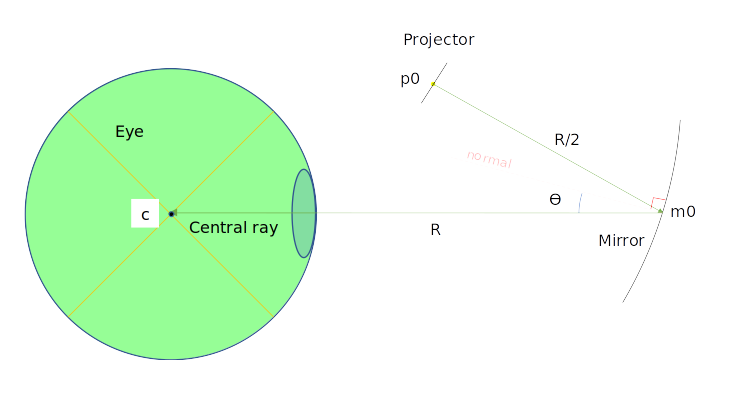

In [3]:
# create vectors to pixel from mirror and to eye center from mirror
var p0_m0 = p0 - m0
var c_m0 = c - m0

# theta is the half-angle between them - the angle from the normal at the mirror
var theta = math.acos(p0_m0.cosine(c_m0)) / 2

# a rotation for the mirror half angle
var Mtheta = Rotate2D(theta) 

# we should have R=60, and theta=pi/8
print (c_m0.length(), theta, pi / 8)

60.0 0.3926990816987242 0.39269908169872414


![first ray.png](<attachment:first ray.png>)
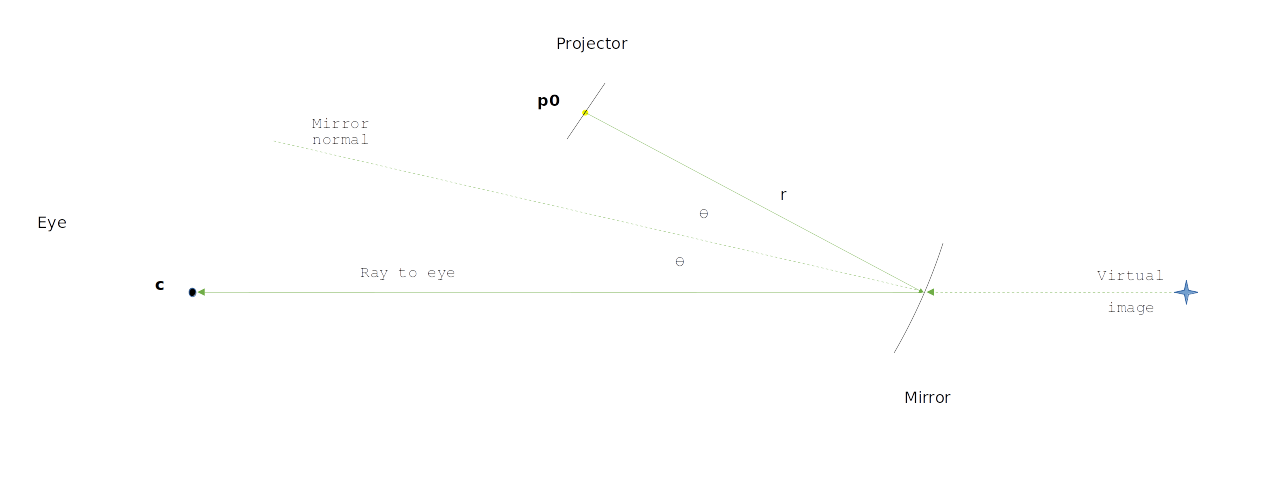

In [4]:
var r = p0_m0.length()
var p = p0_m0.cosine(c_m0) * r
var q = math.sqrt(r*r - p*p)

# q^2 / 2(p + s) = s		parabola with p_s axis from focus to center
# s^2 + ps – q^2/2 = 0

var s = (-p + math.sqrt(p*p + 2 * q*q))/2

print("horizontal p = ", p, ", q = ", q, ", r = ", r, ", s = ", s)

# verify the parabola fits at m0.  Height should equal s
var k = 1 / (2 *(p + s))
var height = k * q * q
print(height)

horizontal p =  21.213200000000001 , q =  21.213200000000004 , r =  29.999995141332942 , s =  7.7645700955600567
7.7645700955600558


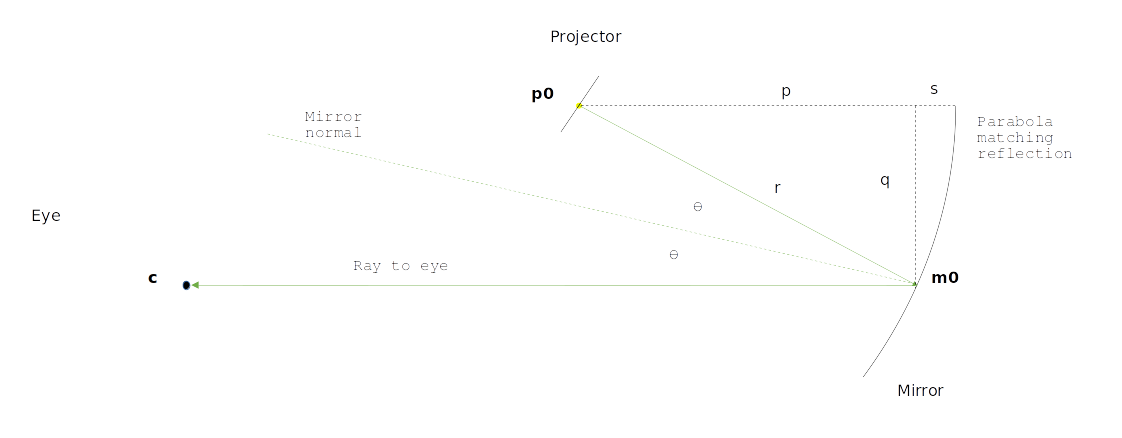

In [5]:
# use a step small enough to allow high order terms to be ignored
alias step = 0.03 # mm

# 350 * .03 is about 10.5mm which is a bit over 20 degrees at a 30mm radius.
#  This will be below and above center, so over 40 degrees total.

alias facetCount = 350

# the mirror and projector shapes will be built out from their edges in very small sideways steps adding to q vector

var q1 = q + step
var s1 = k * q1 * q1

var pStep = c_m0.unit() * (s1 - s)
var qStep = c_m0.unit().normal() * step

print(pStep.x, pStep.y, qStep.x, qStep.y)

var m1 = m0 + qStep + pStep

print(m1.x, m1.y)

-0.021977053372286726 0.0 -0.0 -0.029999999999999999
59.978022946627711 -0.029999999999999999


![make m1.png](<attachment:make m1.png>)
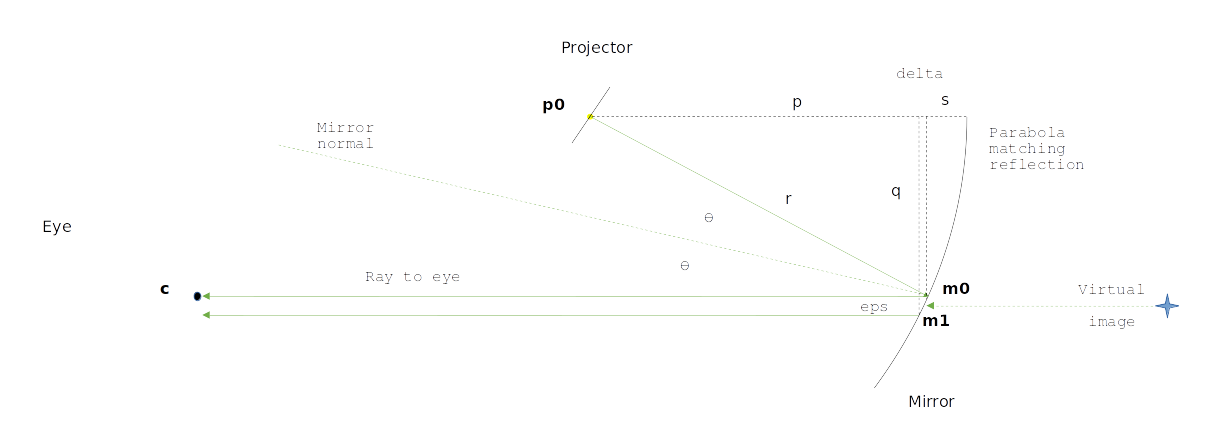

In [6]:
# the next projector pixel is found by working backwards using the new mirror position
# as defining the ray from the eye center and a new parallel goes to the prior mirror position

# Calculate the angular shift of the new mirror point from the eye.
# Eye center is origin(0,0) simplifying the math

var angle0 = math.atan(m0.y / m0.x)
var angle1 = math.atan(m1.y / m1.x)
var angleDif = angle0 - angle1
var RotDif = Rotate2D(angleDif)

# calculate the new reflections from mirror back to projector
var p0_m1 = p0 - m1
var v_a = RotDif.rot(p0_m0)
var v_b = RotDif.rot(p0_m1)

# derive a1 x + b1 y + c1 = 0 for line through p1_a and m0
var a1 = v_a.y
var b1 = -v_a.x
var c1 = -(a1 * m0.x + b1 * m0.y)
# verify zero
var p1_a = m0 + v_a
print((a1 * p1_a.x) + (b1 * p1_a.y) + c1)

# derive a2 x + b2 y + c2 = 0 for line through p1_b and m1
var a2 = v_b.y
var b2 = -v_b.x
var c2 = -(a2 * m1.x + b2 * m1.y)
# verify zero
var p1_b = m1 + v_b
print((a2 * p1_b.x) + (b2 * p1_b.y) + c2)

var p1 = Point2D((b1*c2 - b2*c1) / (a1*b2 - a2*b1), (c1*a2 - c2*a1) / (a1*b2 - a2*b1))

print(angleDif, p0.x, p0.y, p1.x, p1.y)


-2.2737367544323206e-13
0.0
0.00050018316750560234 38.786799999999999 21.213200000000001 38.774542901747338 21.204234478952198


![make p1.png](<attachment:make p1.png>)
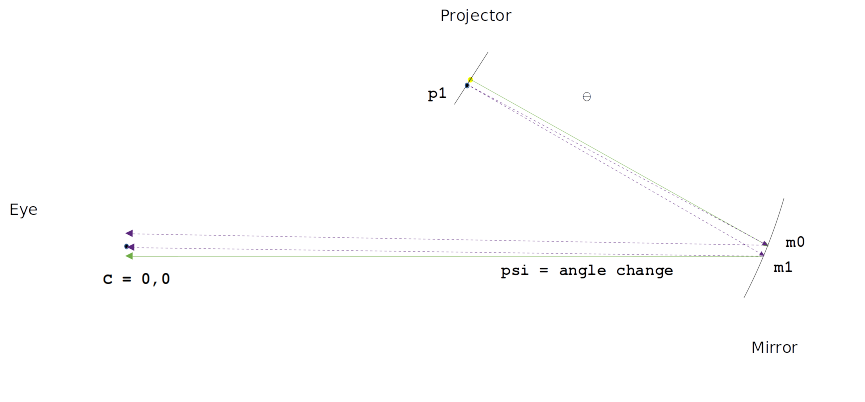

In [7]:
fn stepSurfaces (p0 : Point2D, m0 : Point2D, c : Point2D, step : Float64, verify : Bool) -> ProjectorMirrorPair :
    var p0_m0 = p0 - m0
    var c_m0 = c - m0

    var r = p0_m0.length()
    var p = p0_m0.cosine(c_m0) * r
    var q = math.sqrt(r*r - p*p)

    # q^2 / 2(p + s) = s		parabola with p_s axis from focus to center
    # s^2 + ps – q^2/2 = 0

    var s = (-p + math.sqrt(p*p + 2 * q*q))/2
    var k = 1 / (2 *(p + s))

    # the mirror and projector shapes will be built out from their edges in very small sideways steps adding to q vector

    var q1 = q - step
    var s1 = k * q1 * q1

    var pStep = c_m0.unit() * (s - s1)
    var qStep = c_m0.unit().normal() * step
    var m1 = m0 + qStep + pStep

    if verify :
        print(m1.x, m1.y)

    # the next projector pixel is found by working backwards using the new mirror position
    # as defining the ray from the eye center and a new parallel goes to the prior mirror position

    # we calculate the angular shift this requires.
    # Eye center is origin(0,0) simplifying the math

    var angle0 = math.atan(m0.y / m0.x)
    var angle1 = math.atan(m1.y / m1.x)
    var angleDif = angle0 - angle1
    var RotDif = Rotate2D(angleDif)

    # calculate the new reflections from mirror back to projector
    var p0_m1 = p0 - m1
    var v_a = RotDif.rot(p0_m0)
    var v_b = RotDif.rot(p0_m1)

    # derive a1 x + b1 y + c1 = 0 for line through p1_a and m0
    var a1 = v_a.y
    var b1 = -v_a.x
    var c1 = -(a1 * m0.x + b1 * m0.y)

    # derive a2 x + b2 y + c2 = 0 for line through p1_b and m1
    var a2 = v_b.y
    var b2 = -v_b.x
    var c2 = -(a2 * m1.x + b2 * m1.y)

    var p1 = Point2D((b1*c2 - b2*c1) / (a1*b2 - a2*b1), (c1*a2 - c2*a1) / (a1*b2 - a2*b1))
    if verify :
        # verify zero
        print((a1 * p1.x) + (b1 * p1.y) + c1)
        print((a2 * p1.x) + (b2 * p1.y) + c2)

    return ProjectorMirrorPair(p1, m1)


In [10]:
alias center = facetCount

var projs = Array[Point2D, (2 * facetCount) + 1]()
var mirs = Array[Point2D, (2 * facetCount) + 1]()
projs[center] = p0
mirs[center] = m0

# build the mirror by iterating angular steps sized phi relative to the projector
# start at the center
# first, build the steps down to index 0 of the arrays, the lower edge

for i in range(0, facetCount) :
    var verify = False # 0 == (i % 100)
    var newPairDown = stepSurfaces (projs[center - i], mirs[center - i], c, step, verify)
    projs[center - i - 1] = newPairDown.p
    mirs[center - i - 1] = newPairDown.m

    var newPairUp = stepSurfaces (projs[center + i], mirs[center + i], c, -step, verify)
    projs[center + i + 1] = newPairUp.p
    mirs[center + i + 1] = newPairUp.m

lower = 0
upper = 2 * facetCount

# print (lower, projs[lower].x, projs[lower].y, mirs[lower].p.x, mirs[lower].p.y, mirs[lower].tan)
# print (center, projs[center].x, projs[center].y, mirs[center].p.x, mirs[center].p.y, mirs[center].tan)
# print (upper, projs[upper].x, projs[upper].y, mirs[upper].p.x, mirs[upper].p.y, mirs[upper].tan)

for i in range(0, (2 * facetCount) + 1, 50) :
    print (i, ", ", projs[i].x, ", ", projs[i].y, ", ", mirs[i].x, ", ", mirs[i].y)


0 ,  33.522266383283615 ,  18.354191753873494 ,  51.181465024648965 ,  -9.715872251235167
50 ,  34.397213336109331 ,  18.728678459151332 ,  52.566308507204489 ,  -8.4352113991507629
100 ,  35.230254312124153 ,  19.11409823365954 ,  53.91384888753386 ,  -7.1159489000304026
150 ,  36.021942871456524 ,  19.510879269564313 ,  55.221315951627631 ,  -5.7596507162631232
200 ,  36.772850199301629 ,  19.919239214052634 ,  56.486076424609386 ,  -4.3680230199328358
250 ,  37.483561666936168 ,  20.339203541786837 ,  57.705642011480926 ,  -2.9428964122640338
300 ,  38.154675051391166 ,  20.770624467761479 ,  58.877676226157014 ,  -1.4862106672404929
350 ,  38.786799999999999 ,  21.213200000000001 ,  60.0 ,  0.0
400 ,  39.379632305688965 ,  21.667054936401996 ,  61.073177635518356 ,  1.5131076155359815
450 ,  39.934739960173779 ,  22.131111869391898 ,  62.092765097198708 ,  3.0515143127391511
500 ,  40.452774093346825 ,  22.604711831457902 ,  63.057081219420837 ,  4.6129838257861406
550 ,  40.934401